In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import os
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model, Sequential

from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D

# Combining and Creating the dataset

In [32]:
import os
import shutil
import random

In [33]:
source1_dir = '/kaggle/input/unsplash-random-images-collection/unsplash-images-collection'  # Folder containing data source 1
source2_dir = '/kaggle/input/covid19-detection/Data/Normal'  # Folder containing data source 2
source3_dir = '/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal'  # Folder containing data source 3

In [34]:
# Destination folder where the new dataset will be created
main_data_dir = '/kaggle/working/main_data_dir'  # This will be created in the working directory

# Subfolders where the images will be copied
random_dir = os.path.join(main_data_dir, 'random')
lungs_dir = os.path.join(main_data_dir, 'lungs')
kidney_dir = os.path.join(main_data_dir, 'kidney')

In [35]:
# Create the main directory and subdirectories
os.makedirs(random_dir, exist_ok=True)
os.makedirs(lungs_dir, exist_ok=True)
os.makedirs(kidney_dir, exist_ok=True)


In [36]:
# Function to copy random images from a source to a destination
def copy_random_images(source_dir, dest_dir, num_images):
    # Get list of all image filenames in the source directory
    all_images = os.listdir(source_dir)
    
    # Randomly select the required number of images
    selected_images = random.sample(all_images, num_images)
    
    # Copy each selected image to the destination folder
    for img in selected_images:
        src_img_path = os.path.join(source_dir, img)
        dest_img_path = os.path.join(dest_dir, img)
        shutil.copy(src_img_path, dest_img_path)

In [37]:
# Copy 802 images from source1 to the 'random' folder
copy_random_images(source1_dir, random_dir, 802)

# Copy 1000 images from source2 to the 'lungs' folder
copy_random_images(source2_dir, lungs_dir, 1000)

# Copy 1000 images from source3 to the 'kidney' folder
copy_random_images(source3_dir, kidney_dir, 1000)

print("Images have been successfully copied to the respective folders.")

Images have been successfully copied to the respective folders.


# Preprocessing the dataset

In [38]:
# Define parameters
batch_size = 32
img_height = 224
img_width = 224
data_dir = '/kaggle/working/main_data_dir'
num_files = 3500

In [39]:
train = tf.keras.utils.image_dataset_from_directory(data_dir, image_size=(img_height, img_width),
                                                     validation_split=0.1, subset='training', seed=123,
                                                     batch_size=batch_size)

val = tf.keras.utils.image_dataset_from_directory(data_dir, image_size=(img_height, img_width),
                                                   validation_split=0.2, subset='validation', seed=123,
                                                   batch_size=batch_size)


Found 2802 files belonging to 3 classes.
Using 2522 files for training.
Found 2802 files belonging to 3 classes.
Using 560 files for validation.


In [40]:
label_to_class_name = dict(zip(range(len(train.class_names)), train.class_names))
label_to_class_name

{0: 'kidney', 1: 'lungs', 2: 'random'}

In [41]:
for image_batch, labels_batch in train:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


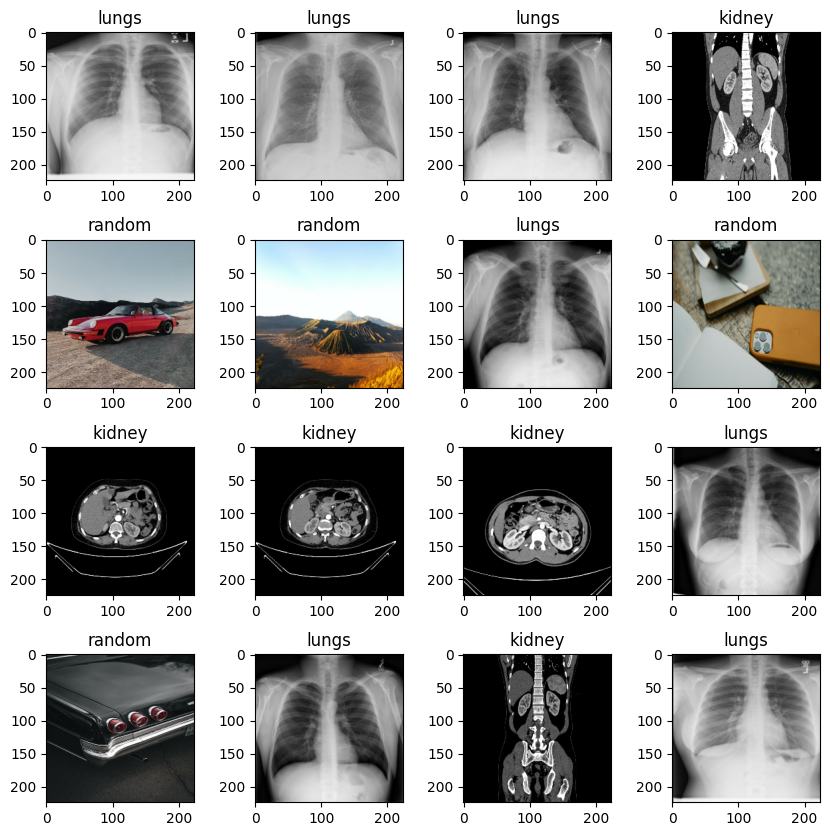

In [42]:
data_iterator = train.as_numpy_iterator()
batch = data_iterator.next()
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))
for i in range(4):  
    for j in range(4):  
        index = i * 4 + j  
        ax[i, j].imshow(batch[0][index].astype(int))
        ax[i, j].set_title(label_to_class_name[batch[1][index]])
plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()

In [43]:
def augment_image(image):
    # Convert image to float32 if it's not already
    image = tf.image.convert_image_dtype(image, tf.float32)
    
    # Apply random transformations
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    
    # Optionally resize or crop the image
    image = tf.image.resize_with_crop_or_pad(image, target_height=224, target_width=224)
    
    return image


In [44]:
# Apply the transformations to the train dataset
train = train.map(lambda x, y: (augment_image(x), y))

# Normalize validation dataset
val = val.map(lambda x, y: (tf.image.convert_image_dtype(x, tf.float32), y))

In [45]:
AUTOTUNE = tf.data.AUTOTUNE

train = train.cache().prefetch(buffer_size=AUTOTUNE)
val = val.cache().prefetch(buffer_size=AUTOTUNE)

# VGG model for Category classification of medical imaging

In [46]:
from tensorflow.keras.applications import VGG16  # or VGG19
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

In [47]:
print(tf.__version__)

2.16.1


In [48]:
input_shape = (224, 224, 3)

# Load VGG model without the top classification layer
vgg_model = VGG16(input_shape=input_shape, weights='imagenet', include_top=False)

# Freeze the first 15 layers
for layer in vgg_model.layers[:15]:
    layer.trainable = False

# Add custom layers on top of the VGG model
x = GlobalAveragePooling2D()(vgg_model.output)
x = Dense(512, activation='relu', kernel_regularizer=l2(1e-3))(x)  # Increase regularization
x = BatchNormalization()(x)  # Add Batch Normalization
x = Dropout(0.6)(x)  # Increase Dropout rate
output = Dense(4, activation='softmax')(x)

In [49]:
# Create the model
vgg_net = Model(inputs=vgg_model.input, outputs=output)

# Compile the model
optimizer = Adam(learning_rate=1e-4)
vgg_net.compile(optimizer=optimizer,
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

In [50]:
# Print model summary
vgg_net.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 4)              │         2,05

 Total params: 14,981,444 (57.15 MB)

 Trainable params: 7,345,156 (28.02 MB)

 Non-trainable params: 7,636,288 (29.13 MB)

In [51]:
epochs=10
history = VGG_model.fit(
  train,
  validation_data=val,
  epochs=epochs
)

Epoch 1/10


I0000 00:00:1726274062.291924     107 service.cc:145] XLA service 0x7c4ef00015d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726274062.291985     107 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1726274062.291991     107 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 1/79 ━━━━━━━━━━━━━━━━━━━━ 23:33 18s/step - accuracy: 0.4062 - loss: 1.8683

I0000 00:00:1726274078.242240     107 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


79/79 ━━━━━━━━━━━━━━━━━━━━ 56s 481ms/step - accuracy: 0.9045 - loss: 0.3026 - val_accuracy: 0.9964 - val_loss: 0.0173
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 13s 164ms/step - accuracy: 0.9998 - loss: 0.0024 - val_accuracy: 0.9982 - val_loss: 0.0023
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 13s 160ms/step - accuracy: 1.0000 - loss: 0.0029 - val_accuracy: 1.0000 - val_loss: 0.0011
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 12s 157ms/step - accuracy: 1.0000 - loss: 7.9532e-04 - val_accuracy: 1.0000 - val_loss: 4.8911e-04
Epoch 5/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 12s 156ms/step - accuracy: 1.0000 - loss: 6.7684e-04 - val_accuracy: 1.0000 - val_loss: 2.8664e-04
Epoch 6/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 13s 160ms/step - accuracy: 1.0000 - loss: 6.1681e-04 - val_accuracy: 1.0000 - val_loss: 2.6199e-04
Epoch 7/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 13s 161ms/step - accuracy: 1.0000 - loss: 4.2151e-04 - val_accuracy: 1.0000 - val_loss: 1.9423e-04
Epoch 8/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 13s 161ms/step - accuracy: 1.0000 - lo

In [52]:
VGG_model.save('Category_validation.h5')

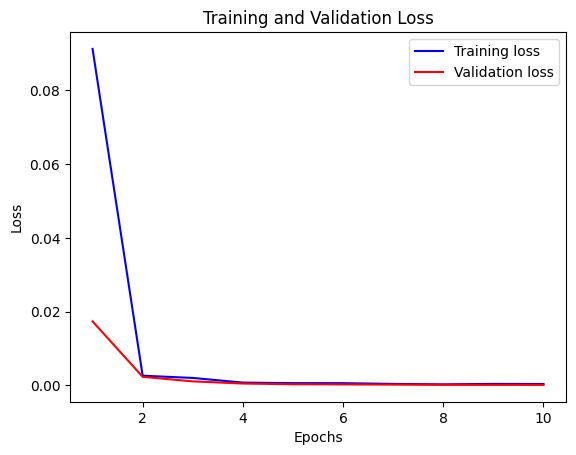

In [53]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

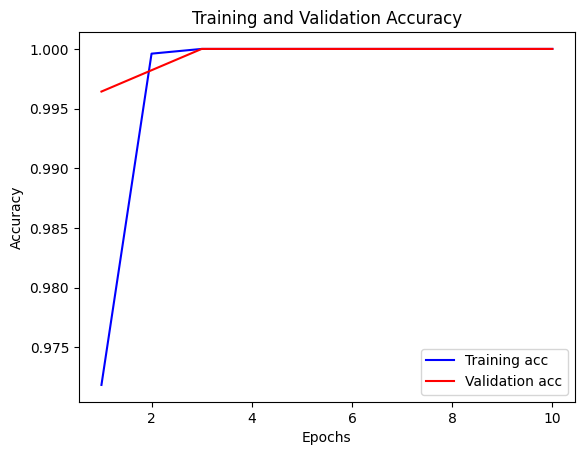

In [54]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf


In [56]:
import pickle
from sklearn.metrics import confusion_matrix
import tensorflow as tf
predictions = VGG_model.predict(val)

true_labels = np.concatenate([y for x, y in val], axis=0)

cm = confusion_matrix(true_labels, np.argmax(predictions, axis=1))

with open('confusion_matrix.pkl', 'wb') as f:
    pickle.dump(cm, f)


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step


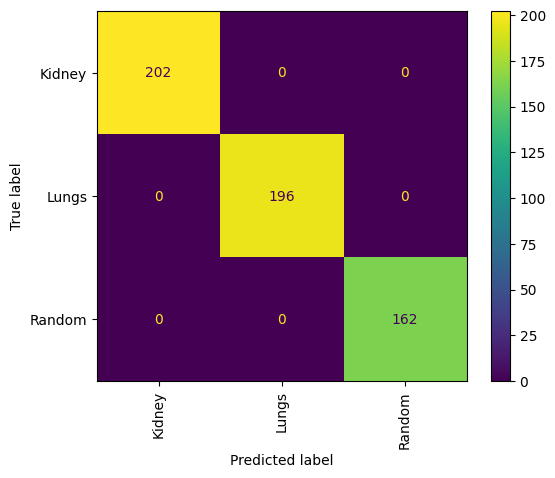

In [59]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

with open('confusion_matrix.pkl', 'rb') as f:
    cm = pickle.load(f)

class_names = ['Kidney', 'Lungs', 'Random']  

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='viridis', xticks_rotation='vertical', values_format='d')

plt.show()


In [60]:
from sklearn.metrics import accuracy_score, f1_score

# Calculate accuracy
accuracy = accuracy_score(true_labels, np.argmax(predictions, axis=1))
print(f"Accuracy: {accuracy:.4f}")


# Calculate F1 score for each class and the weighted average
f1 = f1_score(true_labels, np.argmax(predictions, axis=1), average='weighted')
print(f"F1 Score (weighted): {f1:.4f}")

Accuracy: 1.0000
F1 Score (weighted): 1.0000


In [73]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.vgg16 import decode_predictions


In [74]:
# Define the class labels as per your model
class_labels = {0: 'Kidney', 1: 'Lungs', 2: 'Random'}


In [75]:
# Load the pre-trained model
model = load_model('/kaggle/working/Category_validation.h5')


In [76]:

# Function to preprocess the image
def preprocess_image(img_path):
    # Load the image with the target size for VGG16
    img = image.load_img(img_path, target_size=(224, 224))
    # Convert the image to a numpy array
    img_array = image.img_to_array(img)
    # Add a batch dimension
    img_array = np.expand_dims(img_array, axis=0)
    # Preprocess the image for the VGG16 model
    img_array = preprocess_input(img_array)
    return img_array

# Predict function
def predict_image(img_path):
    # Preprocess the image
    img_array = preprocess_image(img_path)
    # Make a prediction
    predictions = model.predict(img_array)
    # Get the predicted class index
    predicted_class_index = np.argmax(predictions[0])
    # Map the index to the class label
    predicted_label = class_labels.get(predicted_class_index, 'Unknown')
    return predicted_label


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
The predicted class is: Random


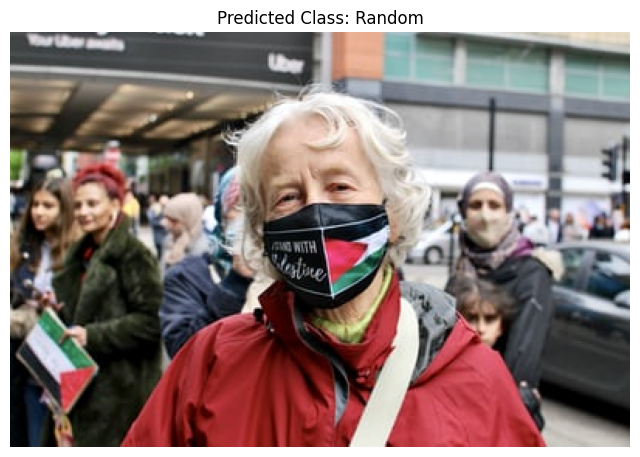

In [81]:
from PIL import Image

image_path = '/kaggle/working/main_data_dir/random/photo-1635674367453-924e9a6e7517.jpg'

# Predict the class
predicted_class = predict_image(image_path)
print(f'The predicted class is: {predicted_class}')

# Load and display the image
img = Image.open(image_path)

# Plot the image and prediction
plt.figure(figsize=(8, 6))
plt.imshow(img)
plt.title(f'Predicted Class: {predicted_class}')
plt.axis('off')  # Hide the axes
plt.show()